# Goal
We want to predict a few different sets of 15d data in 2017, to see how we might perform on test data


On features:
- Want to use many features + LGBM type shit
    - maybe we train on a few months, but those months are using features that shift for years
    - then we test on 15d
- We make features FIRST
    - ex. 1d lag, 14d lag, 1 year, % difs.
    - in reality we won't actually have 1d lag on everything, but presume that we do

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

In [45]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
transactions_df = pd.read_csv('data/transactions.csv')
oil_df = pd.read_csv('data/oil.csv')
holidays_df = pd.read_csv('data/holidays_events.csv')
stores_df = pd.read_csv('data/stores.csv')

train_df = train_df.drop(columns='id')
train_df['date'] = pd.to_datetime(train_df['date'])

mask = oil_df.isna().sum(axis=1).astype(bool)
oil_df = oil_df.ffill().bfill()
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Feature Engineering

Same fam/store
1. Lagged sales (1d, 7d, etc. lag - same fam/store)
2. Rolling sales (1d, 7d, etc. roll - same fam/store)
3. Day of month effect (same day / all days of month, same day / prev day - same fam/store)
4. Yearly fluctuations (day of year / prev day, day of year / prev 7 days - same fam/store)

In [55]:
# FEATURE ENGINEERING TIME

# combined will be the running combined df
combined = train_df.copy()

# 1. 1d, 7d, 2w, 1year lag, for the same fam/store_nbr
for lag in ['1D', '7D', '14D']:
    shiftd = train_df.copy()
    shiftd['date'] = shiftd['date'] + pd.Timedelta(lag)
    shiftd = shiftd[['date', 'store_nbr', 'family', 'sales']].rename(columns={'sales': f'sales{lag}'})
    combined = pd.merge(combined, shiftd, how='inner', on=['date', 'store_nbr', 'family'])

combined.head(20)

,date,store_nbr,family,sales,onpromotion,sales1D,sales7D,sales14D
0,2013-01-15,1,AUTOMOTIVE,1.000,0,2.000,2.000,0.0
1,2013-01-15,1,BABY CARE,0.000,0,0.000,0.000,0.0
2,2013-01-15,1,BEAUTY,0.000,0,2.000,3.000,0.0
3,2013-01-15,1,BEVERAGES,1149.000,0,1178.000,1029.000,0.0
4,2013-01-15,1,BOOKS,0.000,0,0.000,0.000,0.0
5,2013-01-15,1,BREAD/BAKERY,285.612,0,281.286,321.851,0.0
6,2013-01-15,1,CELEBRATION,0.000,0,0.000,0.000,0.0
7,2013-01-15,1,CLEANING,686.000,0,692.000,827.000,0.0
8,2013-01-15,1,DAIRY,357.000,0,411.000,384.000,0.0
9,2013-01-15,1,DELI,100.801,0,144.155,130.085,0.0


In [56]:
# 2. rolling (over the past 1w, what is avg)

for lag in ['1D', '7D', '14D']:
    rollingd = train_df.groupby(['store_nbr', 'family']).rolling(lag, on='date', closed='left')['sales'].mean()
    rollingd = rollingd.reset_index().rename(columns={'sales': f'rolling{lag}'})
    combined = pd.merge(combined, rollingd, how='inner', on=['date', 'store_nbr', 'family'])

combined.head(10)

,date,store_nbr,family,sales,onpromotion,sales1D,sales7D,sales14D,rolling1D,rolling7D,rolling14D
0,2013-01-15,1,AUTOMOTIVE,1.000,0,2.000,2.000,0.0,2.000,2.142857,2.142857
1,2013-01-15,1,BABY CARE,0.000,0,0.000,0.000,0.0,0.000,0.000000,0.000000
2,2013-01-15,1,BEAUTY,0.000,0,2.000,3.000,0.0,2.000,1.571429,1.428571
3,2013-01-15,1,BEVERAGES,1149.000,0,1178.000,1029.000,0.0,1178.000,998.285714,905.428571
4,2013-01-15,1,BOOKS,0.000,0,0.000,0.000,0.0,0.000,0.000000,0.000000
5,2013-01-15,1,BREAD/BAKERY,285.612,0,281.286,321.851,0.0,281.286,282.081140,265.153999
6,2013-01-15,1,CELEBRATION,0.000,0,0.000,0.000,0.0,0.000,0.000000,0.000000
7,2013-01-15,1,CLEANING,686.000,0,692.000,827.000,0.0,692.000,666.142857,663.071429
8,2013-01-15,1,DAIRY,357.000,0,411.000,384.000,0.0,411.000,381.285714,374.071429
9,2013-01-15,1,DELI,100.801,0,144.155,130.085,0.0,144.155,117.896857,111.737357


In [48]:
# 3. percentage difs
# effects to capture: weekly cycles, monthly cycles, yearly cycles
# a. last week, how did this day of week compare to other days averaged?
    # 1w ago / 1w shift --> rolling average
# b. 

train_df.groupby()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


# Modelling
Using all our features, we now need to predict

- "Cross Val": predicting different time periods in 2017 using prev. year data
    - train on 2013 - 2016, test on 2017 (simply pass in lagged features)

In [40]:
# Modified to change object to category
def memory_reduce(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category':
            if np.issubdtype(col_type, np.integer):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif np.issubdtype(col_type, np.floating):
                df[col] = pd.to_numeric(df[col], downcast='float')

        if col_type == object:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
          f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df


cleaned = combined.copy()
cleaned = memory_reduce(cleaned)


Memory usage reduced from 247.96 MB to 112.71 MB (54.5% reduction)


In [41]:
import lightgbm as lgb

dates = cleaned['date']
X = cleaned.drop(columns=['date', 'sales'])
y = cleaned['sales']

X_train, y_train = X[dates < pd.to_datetime('2017-01-01')], y[dates < pd.to_datetime('2017-01-01')]
X_test, y_test = X[dates >= pd.to_datetime('2017-01-01')], y[dates >= pd.to_datetime('2017-01-01')]

In [ ]:
categorical_features = X_train.select_dtypes(include='category').columns

model = lgb.LGBMRegressor(
            n_estimators=100,
            num_leaves=31,
            learning_rate = 0.1
        )

model.fit(X_train, np.log1p(y_train), categorical_feature=categorical_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 2553606, number of used features: 9
[LightGBM] [Info] Start training from score 2.837846


LGBMRegressor()

In [43]:
predictions = model.predict(X_test)
root_mean_squared_error(predictions, np.log1p(y_test))

0.4357885707188897

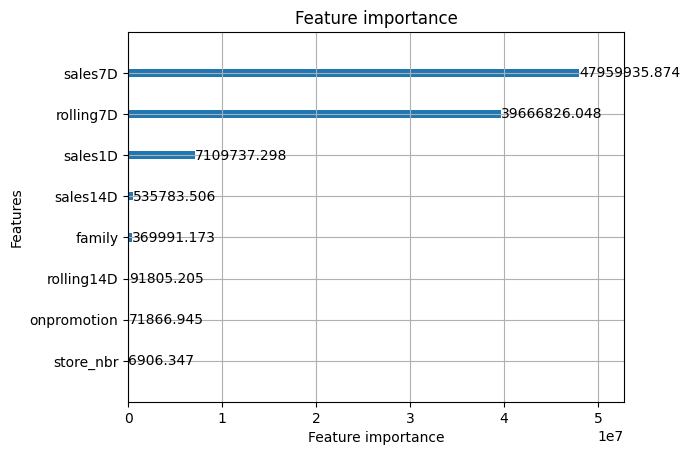

In [33]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')  # or 'gain'
plt.show()